## Content
1. [Load data](#1.-Load-data)  
2. [Diving into data](#2.-Diving-into-data)  
3. [Data preprocessing](#3.-Data-preprocessing)  
4. [Training word2vec model](#4.-Training-word2vec-model)  

In [1]:
import numpy as np
import pandas as pd

from pprint import pprint
from tqdm import tqdm

IN_PATH = '../data/'
WORD_EMBEDDINGS_PATH = '../word_embeddings/'
MAX_NR_OF_COMMENTS = None
target_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## 1. Load data

In [2]:
train_df = pd.read_csv(IN_PATH + 'train.csv', encoding='utf8')
test_df = pd.read_csv(IN_PATH + 'test.csv', encoding='utf8')

In [3]:
if MAX_NR_OF_COMMENTS is not None:
    print('MAX_NR_OF_COMMENTS: {}'.format(MAX_NR_OF_COMMENTS))
    train_df = train_df.head(MAX_NR_OF_COMMENTS)
    test_df = test_df.head(MAX_NR_OF_COMMENTS)

## 2. Diving into data

### 2.1 General info

In [4]:
print(train_df[0:5])

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
comment = train_df['comment_text'][0]
print(comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
print(type(comment))

<type 'unicode'>


In [7]:
print(train_df.shape)
print(test_df.shape)

(159571, 8)
(153164, 2)


### 2.2 Data distribution

In [8]:
def comments_lengths_char(df):
    return [len(comment) for comment in df['comment_text']]

In [9]:
train_comments_lengths_chars = comments_lengths_char(train_df)
test_comments_lengths_chars = comments_lengths_char(test_df)

In [10]:
from nltk.tokenize import WordPunctTokenizer
word_punct_tokenizer = WordPunctTokenizer()

def comments_lengths_words(df):
    lengths = list()
    words = list()
    n = 0
    
    for comment in df['comment_text']:
        words.append([])
        comment_length = 0
        
        for word in word_punct_tokenizer.tokenize(comment):
            if word.isalpha():
                comment_length += 1
                words[n].append(word)
                
        lengths.append(comment_length)
        n += 1
        
    return (lengths, words)

In [11]:
(train_comments_lengths_words, train_comment_words) = comments_lengths_words(train_df)
(test_comments_lengths_words, test_comment_words) = comments_lengths_words(test_df)

In [12]:
comment_0_words = word_punct_tokenizer.tokenize(train_df['comment_text'][0])
filtered_comment_0_words = train_comment_words[0]

print(comment_0_words)
print(filtered_comment_0_words)

[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'?', u'They', u'weren', u"'", u't', u'vandalisms', u',', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'.', u'And', u'please', u'don', u"'", u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u"'", u'm', u'retired', u'now', u'.', u'89', u'.', u'205', u'.', u'38', u'.', u'27']
[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'They', u'weren', u't', u'vandalisms', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'And', u'please', u'don', u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u'm', u'retired', u'now']


In [13]:
def show_hists(x_train, x_test, values_name=''):
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.6)
    
    axs[0].hist(x_train)
    axs[0].set_xlabel('number of ' + values_name)
    axs[0].set_ylabel('frequency')
    axs[0].set_title('train set')
    
    axs[1].hist(x_test)
    axs[1].set_xlabel('number of ' + values_name)
    axs[1].set_ylabel('frequency')
    axs[1].set_title('test set')

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

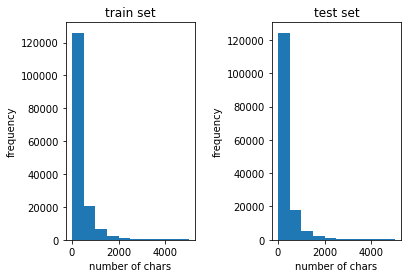

In [15]:
show_hists(train_comments_lengths_chars, test_comments_lengths_chars, 'chars')

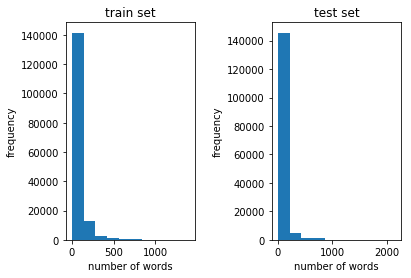

In [16]:
show_hists(train_comments_lengths_words, test_comments_lengths_words, 'words')

## 3. Data preprocessing

### 3.1 Tokenize-filter-lower

In [17]:
def tokenize_filter_lower(df):
    words = list()
    n = 0
    
    for comment in df['comment_text']:
        words.append([])        
        for word in word_punct_tokenizer.tokenize(comment):
            if word.isalpha():
                words[n].append(word.lower())
        n += 1
        
    return words

In [18]:
train_tokens = tokenize_filter_lower(train_df)
test_tokens = tokenize_filter_lower(test_df)

In [19]:
pprint(train_tokens[0][0:20])

[u'explanation',
 u'why',
 u'the',
 u'edits',
 u'made',
 u'under',
 u'my',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'were',
 u'reverted',
 u'they',
 u'weren',
 u't',
 u'vandalisms',
 u'just',
 u'closure',
 u'on']


### 3.2 Lemmatization

** Conversion from Penn Treebank tag to a simplified Wordnet tag is taken from ** https://nlpforhackers.io/wordnet-sentence-similarity/

In [20]:
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return 'v'

def lemmatization(tokens):   
    lemmas = list()
    n = 0
    pbar = tqdm(total=len(tokens))
    
    for token_row in tokens:
        lemmas.append([])
        for token in token_row:
            penn_tag = pos_tag([token])[0][1]
            wn_tag = penn_to_wn(penn_tag)
            lemma = lemmatizer.lemmatize(token, pos=wn_tag)
            lemmas[n].append(lemma)
        n += 1
        if n % 1000 == 0:
            pbar.update(1000)
    
    pbar.update(len(tokens) - 1000 * int(len(tokens)/1000))
    pbar.close()    
        
    return lemmas

In [21]:
train_lemmas = lemmatization(train_tokens)
test_lemmas = lemmatization(test_tokens)

100%|██████████| 153164/153164 [17:02<00:00, 142.35it/s]


In [22]:
train_lemmas[0][0:20]

[u'explanation',
 u'why',
 u'the',
 u'edits',
 u'make',
 u'under',
 u'my',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'be',
 u'revert',
 u'they',
 u'weren',
 u't',
 u'vandalism',
 u'just',
 u'closure',
 u'on']

### 3.3 Stopwords elimination

In [23]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in set(stopwords_set)]   
    return filtered_tokens

def stopwords_elimination(comments):
    return [remove_stopwords(comment) for comment in comments]

In [24]:
train_preprocessed = stopwords_elimination(train_lemmas)
test_preprocessed = stopwords_elimination(test_lemmas)

In [25]:
pprint(train_preprocessed[0])

[u'explanation',
 u'edits',
 u'make',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'revert',
 u'vandalism',
 u'closure',
 u'gas',
 u'vote',
 u'new',
 u'york',
 u'doll',
 u'fac',
 u'please',
 u'remove',
 u'template',
 u'talk',
 u'page',
 u'since',
 u'retire']


## 4. Training word2vec model
A good tutorial can be found here: https://rare-technologies.com/word2vec-tutorial/  
Good link: https://radimrehurek.com/gensim/models/word2vec.html

In [26]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [27]:
model_sg = 1
model_size = 200
model_min_count = 2
model_negative = 10
model_window = 10

In [28]:
model = gensim.models.Word2Vec(train_comment_words + test_comment_words, sg=model_sg, size=model_size, 
                               min_count=model_min_count,
                               negative=model_negative, window=model_window,
                               workers=5)

2018-05-16 18:57:30,896 : INFO : collecting all words and their counts
2018-05-16 18:57:30,897 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-16 18:57:31,034 : INFO : PROGRESS: at sentence #10000, processed 688925 words, keeping 42375 word types
2018-05-16 18:57:31,171 : INFO : PROGRESS: at sentence #20000, processed 1366359 words, keeping 63569 word types
2018-05-16 18:57:31,292 : INFO : PROGRESS: at sentence #30000, processed 2030874 words, keeping 80498 word types
2018-05-16 18:57:31,426 : INFO : PROGRESS: at sentence #40000, processed 2720130 words, keeping 95520 word types
2018-05-16 18:57:31,566 : INFO : PROGRESS: at sentence #50000, processed 3388878 words, keeping 108511 word types
2018-05-16 18:57:31,717 : INFO : PROGRESS: at sentence #60000, processed 4092316 words, keeping 121111 word types
2018-05-16 18:57:31,857 : INFO : PROGRESS: at sentence #70000, processed 4773127 words, keeping 132764 word types
2018-05-16 18:57:31,995 : INFO : PROG

2018-05-16 18:58:11,605 : INFO : EPOCH 1 - PROGRESS: at 21.72% examples, 106653 words/s, in_qsize 9, out_qsize 0
2018-05-16 18:58:12,677 : INFO : EPOCH 1 - PROGRESS: at 22.48% examples, 106926 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:58:13,791 : INFO : EPOCH 1 - PROGRESS: at 23.20% examples, 106839 words/s, in_qsize 10, out_qsize 1
2018-05-16 18:58:14,824 : INFO : EPOCH 1 - PROGRESS: at 23.96% examples, 107188 words/s, in_qsize 9, out_qsize 0
2018-05-16 18:58:15,940 : INFO : EPOCH 1 - PROGRESS: at 24.66% examples, 107286 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:58:16,963 : INFO : EPOCH 1 - PROGRESS: at 25.37% examples, 107430 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:58:18,087 : INFO : EPOCH 1 - PROGRESS: at 26.14% examples, 107519 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:58:19,145 : INFO : EPOCH 1 - PROGRESS: at 26.89% examples, 107763 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:58:20,206 : INFO : EPOCH 1 - PROGRESS: at 27.60% examples, 107779 words/s, i

2018-05-16 18:59:29,221 : INFO : EPOCH 1 - PROGRESS: at 76.27% examples, 109889 words/s, in_qsize 10, out_qsize 1
2018-05-16 18:59:30,341 : INFO : EPOCH 1 - PROGRESS: at 77.04% examples, 109832 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:31,354 : INFO : EPOCH 1 - PROGRESS: at 77.83% examples, 109881 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:32,393 : INFO : EPOCH 1 - PROGRESS: at 78.52% examples, 109835 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:33,394 : INFO : EPOCH 1 - PROGRESS: at 79.17% examples, 109760 words/s, in_qsize 9, out_qsize 0
2018-05-16 18:59:34,433 : INFO : EPOCH 1 - PROGRESS: at 79.95% examples, 109725 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:35,458 : INFO : EPOCH 1 - PROGRESS: at 80.74% examples, 109760 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:36,493 : INFO : EPOCH 1 - PROGRESS: at 81.44% examples, 109710 words/s, in_qsize 10, out_qsize 0
2018-05-16 18:59:37,539 : INFO : EPOCH 1 - PROGRESS: at 82.27% examples, 109788 words/s, 

2018-05-16 19:00:41,796 : INFO : EPOCH 2 - PROGRESS: at 26.97% examples, 111429 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:00:42,923 : INFO : EPOCH 2 - PROGRESS: at 27.70% examples, 111172 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:00:43,929 : INFO : EPOCH 2 - PROGRESS: at 28.40% examples, 111270 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:00:45,079 : INFO : EPOCH 2 - PROGRESS: at 29.16% examples, 111198 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:00:46,074 : INFO : EPOCH 2 - PROGRESS: at 29.89% examples, 111310 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:00:47,100 : INFO : EPOCH 2 - PROGRESS: at 30.52% examples, 111178 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:00:48,105 : INFO : EPOCH 2 - PROGRESS: at 31.29% examples, 111450 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:00:49,228 : INFO : EPOCH 2 - PROGRESS: at 31.95% examples, 111085 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:00:50,459 : INFO : EPOCH 2 - PROGRESS: at 32.78% examples, 111138 words/s, in_

2018-05-16 19:01:59,904 : INFO : EPOCH 2 - PROGRESS: at 83.39% examples, 112569 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:02:00,969 : INFO : EPOCH 2 - PROGRESS: at 84.20% examples, 112599 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:02:02,018 : INFO : EPOCH 2 - PROGRESS: at 84.96% examples, 112518 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:02:03,057 : INFO : EPOCH 2 - PROGRESS: at 85.70% examples, 112517 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:02:04,074 : INFO : EPOCH 2 - PROGRESS: at 86.54% examples, 112597 words/s, in_qsize 9, out_qsize 1
2018-05-16 19:02:05,114 : INFO : EPOCH 2 - PROGRESS: at 87.33% examples, 112596 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:02:06,143 : INFO : EPOCH 2 - PROGRESS: at 88.13% examples, 112666 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:02:07,157 : INFO : EPOCH 2 - PROGRESS: at 88.90% examples, 112678 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:02:08,242 : INFO : EPOCH 2 - PROGRESS: at 89.62% examples, 112635 words/s, in

2018-05-16 19:03:10,128 : INFO : EPOCH 3 - PROGRESS: at 32.42% examples, 111523 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:03:11,154 : INFO : EPOCH 3 - PROGRESS: at 32.96% examples, 111090 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:12,403 : INFO : EPOCH 3 - PROGRESS: at 33.65% examples, 110646 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:03:13,495 : INFO : EPOCH 3 - PROGRESS: at 34.32% examples, 110510 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:14,495 : INFO : EPOCH 3 - PROGRESS: at 34.87% examples, 110179 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:15,530 : INFO : EPOCH 3 - PROGRESS: at 35.46% examples, 109950 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:16,631 : INFO : EPOCH 3 - PROGRESS: at 36.18% examples, 109829 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:17,672 : INFO : EPOCH 3 - PROGRESS: at 36.93% examples, 109841 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:03:18,710 : INFO : EPOCH 3 - PROGRESS: at 37.51% examples, 109465 words/s, i

2018-05-16 19:04:26,989 : INFO : EPOCH 3 - PROGRESS: at 86.44% examples, 110208 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:04:28,123 : INFO : EPOCH 3 - PROGRESS: at 87.28% examples, 110203 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:04:29,132 : INFO : EPOCH 3 - PROGRESS: at 88.04% examples, 110246 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:04:30,252 : INFO : EPOCH 3 - PROGRESS: at 88.85% examples, 110246 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:04:31,280 : INFO : EPOCH 3 - PROGRESS: at 89.58% examples, 110271 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:04:32,301 : INFO : EPOCH 3 - PROGRESS: at 90.37% examples, 110359 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:04:33,329 : INFO : EPOCH 3 - PROGRESS: at 91.15% examples, 110374 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:04:34,360 : INFO : EPOCH 3 - PROGRESS: at 91.93% examples, 110388 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:04:35,410 : INFO : EPOCH 3 - PROGRESS: at 92.75% examples, 110447 words/s, in

2018-05-16 19:05:37,935 : INFO : EPOCH 4 - PROGRESS: at 35.89% examples, 112770 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:05:39,085 : INFO : EPOCH 4 - PROGRESS: at 36.70% examples, 112645 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:05:40,095 : INFO : EPOCH 4 - PROGRESS: at 37.51% examples, 112952 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:05:41,133 : INFO : EPOCH 4 - PROGRESS: at 38.16% examples, 112778 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:05:42,207 : INFO : EPOCH 4 - PROGRESS: at 38.92% examples, 112827 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:05:43,202 : INFO : EPOCH 4 - PROGRESS: at 39.69% examples, 113001 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:05:44,279 : INFO : EPOCH 4 - PROGRESS: at 40.36% examples, 112774 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:05:45,385 : INFO : EPOCH 4 - PROGRESS: at 41.12% examples, 112869 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:05:46,402 : INFO : EPOCH 4 - PROGRESS: at 41.74% examples, 112623 words/s, in_

2018-05-16 19:06:55,487 : INFO : EPOCH 4 - PROGRESS: at 91.47% examples, 111561 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:06:56,501 : INFO : EPOCH 4 - PROGRESS: at 92.26% examples, 111592 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:06:57,514 : INFO : EPOCH 4 - PROGRESS: at 93.06% examples, 111670 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:06:58,559 : INFO : EPOCH 4 - PROGRESS: at 93.85% examples, 111671 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:06:59,580 : INFO : EPOCH 4 - PROGRESS: at 94.65% examples, 111684 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:07:00,693 : INFO : EPOCH 4 - PROGRESS: at 95.43% examples, 111624 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:07:01,715 : INFO : EPOCH 4 - PROGRESS: at 96.28% examples, 111707 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:07:02,768 : INFO : EPOCH 4 - PROGRESS: at 97.08% examples, 111751 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:07:03,777 : INFO : EPOCH 4 - PROGRESS: at 97.82% examples, 111780 words/s, in_

2018-05-16 19:08:07,416 : INFO : EPOCH 5 - PROGRESS: at 38.47% examples, 104782 words/s, in_qsize 10, out_qsize 1
2018-05-16 19:08:08,463 : INFO : EPOCH 5 - PROGRESS: at 39.16% examples, 104867 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:08:09,470 : INFO : EPOCH 5 - PROGRESS: at 39.79% examples, 104787 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:08:10,642 : INFO : EPOCH 5 - PROGRESS: at 40.45% examples, 104553 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:08:11,853 : INFO : EPOCH 5 - PROGRESS: at 41.12% examples, 104361 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:08:12,855 : INFO : EPOCH 5 - PROGRESS: at 41.78% examples, 104418 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:08:13,906 : INFO : EPOCH 5 - PROGRESS: at 42.45% examples, 104407 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:08:14,920 : INFO : EPOCH 5 - PROGRESS: at 43.06% examples, 104330 words/s, in_qsize 10, out_qsize 1
2018-05-16 19:08:15,980 : INFO : EPOCH 5 - PROGRESS: at 43.80% examples, 104495 words/s, 

2018-05-16 19:09:25,023 : INFO : EPOCH 5 - PROGRESS: at 93.00% examples, 106796 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:09:26,033 : INFO : EPOCH 5 - PROGRESS: at 93.80% examples, 106863 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:09:27,140 : INFO : EPOCH 5 - PROGRESS: at 94.65% examples, 106897 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:09:28,190 : INFO : EPOCH 5 - PROGRESS: at 95.43% examples, 106927 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:09:29,213 : INFO : EPOCH 5 - PROGRESS: at 96.23% examples, 106977 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:09:30,218 : INFO : EPOCH 5 - PROGRESS: at 96.97% examples, 107044 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:09:31,243 : INFO : EPOCH 5 - PROGRESS: at 97.72% examples, 107083 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:09:32,381 : INFO : EPOCH 5 - PROGRESS: at 98.60% examples, 107165 words/s, in_qsize 10, out_qsize 0
2018-05-16 19:09:33,456 : INFO : EPOCH 5 - PROGRESS: at 99.40% examples, 107221 words/s, in_

In [29]:
model.save('{}model_sg_{}_size_{}_min_count_{}_negative_{}_window_{}'.format(WORD_EMBEDDINGS_PATH, 
                                                                             model_sg, model_size,
                                                                             model_min_count,
                                                                             model_negative,
                                                                             model_window))

2018-05-16 19:09:34,382 : INFO : saving Word2Vec object under ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10, separately None
2018-05-16 19:09:34,383 : INFO : storing np array 'vectors' to ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10.wv.vectors.npy
2018-05-16 19:09:34,889 : INFO : not storing attribute vectors_norm
2018-05-16 19:09:34,889 : INFO : storing np array 'syn1neg' to ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10.trainables.syn1neg.npy
2018-05-16 19:09:35,382 : INFO : not storing attribute cum_table
2018-05-16 19:09:37,800 : INFO : saved ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10
